In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [1]:
import sys
import os

sys.path.append('../tools')
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from tqdm import tqdm
import sklearn

import torchvision.transforms as T
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

import data_utility
import times
import segmentation
import preprocess
import autoencoder
import visualizer
import kaggle_data_utility

In [2]:
data_dir = "../../../user_data/competition_data/clips"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

# targets = [
#     'Dog_1',
#     'Dog_2',
#     'Dog_3',
#     'Dog_4',
# ]

targets = [
    'Patient_1',
    'Patient_2',
    'Patient_3',
    'Patient_4',
    'Patient_5',
    'Patient_6',
    'Patient_7',
    'Patient_8'
]

In [3]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
determine_generator = torch.Generator()
determine_generator.manual_seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

In [4]:
# ictal_data_list = [kaggle_data_utility.parse_input_data(data_dir, targets[i], 'ictal', None) for i in
#                    range(len(targets))]
# interictal_data_list = [kaggle_data_utility.parse_input_data(data_dir, targets[i], 'interictal', None) for i in
#                         range(len(targets))]
# test_data_list = [kaggle_data_utility.parse_input_data(data_dir, targets[i], 'test', None) for i in range(len(targets))]

In [5]:
data_X = np.load('../../../user_data/kaggle_human_cache/data_X_5.npy')
data_y = np.load('../../../user_data/kaggle_human_cache/data_y_5.npy')
test_data_X = None

In [6]:
from models.kaggle_human_dataloader import KaggleDataset
labeled_dataset = KaggleDataset(data_X, data_y, test_data_X, labeled=True, transform=False, astensor=False)
# train_set_size = int(unlabeled_dataset.length * 0.8)
# valid_set_size = unlabeled_dataset.length - train_set_size
# train_set, test_set = torch.utils.data.random_split(unlabeled_dataset, [train_set_size, valid_set_size])

In [7]:
def collate_fn(batch):
    info = list(zip(*batch))
    data = info[0]
    label = info[1]
    return torch.stack(data), torch.stack(label)

labeled_dataloader = torch.utils.data.DataLoader(
    labeled_dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)

In [8]:
labeled_dataset.data_y.shape

(2997, 1)

In [9]:
from models.SwaV import SwaV
from models.SupervisedDownstream import SupervisedDownstream
from lightly.data import SwaVCollateFunction
#
swav = SwaV().load_from_checkpoint(ckpt_folder_root + 'kaggle_human_swav_34_5_da/kaggle_human_swav-epoch=12-swav_loss=4.69480.ckpt')
#
model = SupervisedDownstream(swav.backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor='val_loss',filename='kaggle__linear_eval-{epoch:02d}-{val_loss:.5f}', save_last=True, save_top_k=-1, dirpath=ckpt_folder_root + 'kaggle_dog_swav_50_linear_eval')
# csv_logger = pl_loggers.CSVLogger(log_folder_root, name="kaggle_dog_swav_50_linear_eval")

trainer = pl.Trainer(max_epochs=80,accelerator='gpu', devices=1)

predictions = trainer.predict(model,labeled_dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\Patrick Xu\Desktop\RNS_Annotation-Pipeline\scripts\RNS_LITT_ANNOTATION_PIPELINE\kaggle_human_scripts\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [10]:
from torch import nn
output_list = []
target_list = []
emb_list = []
m = nn.Softmax(dim=1)
for pred, y, emb in predictions:
    output_list.append(pred)
    target_list.append(y)
    emb_list.append(emb)

pred_raw = torch.vstack(output_list)
target = torch.vstack(target_list)
emb = torch.vstack(emb_list)
out = torch.argmax(pred_raw, dim=1)

In [11]:
len(emb)

2997

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca_comp_n = 30
batch_size = 32

pca = PCA(n_components=pca_comp_n, copy=True).fit(emb)
p = pca.transform(emb)

# ind = np.random.choice(len(emb), 10000)

tsne = TSNE(n_components=2, verbose=1, perplexity=2, random_state=142, init='pca')
z = tsne.fit_transform(emb)

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 2997 samples in 0.000s...
[t-SNE] Computed neighbors for 2997 samples in 0.170s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2997
[t-SNE] Computed conditional probabilities for sample 2000 / 2997
[t-SNE] Computed conditional probabilities for sample 2997 / 2997
[t-SNE] Mean sigma: 0.309045
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.371727
[t-SNE] KL divergence after 1000 iterations: 1.035623


In [13]:
pca.explained_variance_ratio_

array([7.69395288e-01, 1.63492079e-01, 5.30195059e-02, 8.36759505e-03,
       2.53403260e-03, 7.68709494e-04, 5.69700213e-04, 3.31401040e-04,
       1.89139886e-04, 1.58441904e-04, 1.24759361e-04, 1.08605691e-04,
       9.97790209e-05, 8.96722949e-05, 7.19040637e-05, 6.02365533e-05,
       4.40221747e-05, 4.28567852e-05, 3.87318006e-05, 3.29351090e-05,
       2.94708017e-05, 2.70524933e-05, 2.36170514e-05, 2.18266153e-05,
       2.14981438e-05, 1.65966267e-05, 1.60971354e-05, 1.41840250e-05,
       1.27804062e-05, 1.24625007e-05])

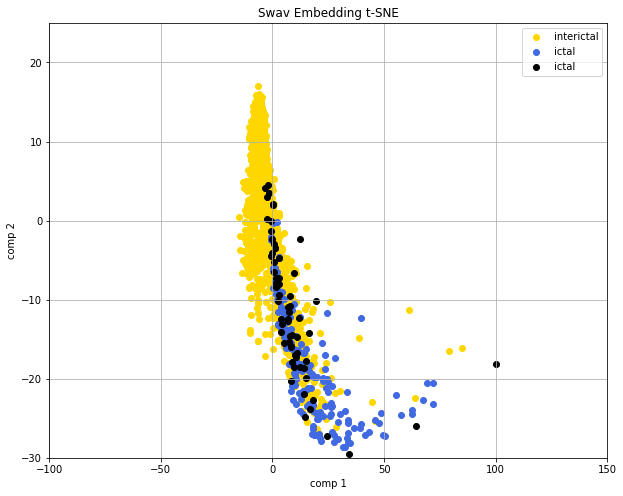

In [17]:
spc = p
ictal_pre_inds = np.where(target == 0)[0]
ictal_inds = np.where(target == 1)[0]
interictal_inds = np.where(target == 2)[0]

plt.figure(figsize=(10, 8))
plt.scatter(spc[interictal_inds,0],spc[interictal_inds,1],c='gold',label= 'interictal')
plt.scatter(spc[ictal_inds, 0], spc[ictal_inds, 1], c='royalblue', label='ictal')
plt.scatter(spc[ictal_pre_inds, 0], spc[ictal_pre_inds, 1], c='black', label='ictal')

plt.title('Swav Embedding t-SNE')
plt.xlabel('comp 1')
plt.ylabel("comp 2")
plt.xlim(-100,150)
plt.ylim(-30,25)
plt.legend()
plt.grid()
plt.show()

In [12]:
# unlabeled_dataset = KaggleDataset(ictal_data_X, interictal_data_X, test_data_X, labeled=False, transform=True)
# train_set_size = int(labeled_dataset.length * 0.8)
# valid_set_size = labeled_dataset.length - train_set_size
# train_set, test_set = torch.utils.data.random_split(labeled_dataset, [train_set_size, valid_set_size])

In [13]:
import torch.nn.functional as F
class SupervisedDownstream(pl.LightningModule):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)
        self.alpha = 0.5
        self.gamma = 8


    def training_step(self, batch, batch_idx):
        x, y = batch
        self.backbone.eval()
        x = self.backbone(x)
        with torch.no_grad():
            x = x.view(-1,512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        pred = self.fc4(x)
        pred = self.softmax(pred)
        label = F.one_hot(y).squeeze()
        loss = sigmoid_focal_loss(pred.float(),label.float(), alpha = self.alpha, gamma = self.gamma,reduction = 'mean')
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = self.backbone(x)
        x = x.view(-1,512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        pred = self.fc4(x)
        pred = self.softmax(pred)
        label = F.one_hot(y).squeeze()
        loss = sigmoid_focal_loss(pred.float(),label.float(), alpha = self.alpha, gamma = self.gamma,reduction = 'mean')
        out = torch.argmax(pred, dim=1)
        out = out.detach().cpu().numpy()
        target = y.squeeze().detach().cpu().numpy()
        precision,recall,fscore,support = sklearn.metrics.precision_recall_fscore_support(out, target)
        acc=sklearn.metrics.accuracy_score(out, target)
        # Logging to TensorBoard (if installed) by default
        self.log("val_loss", loss)
        self.log("val_acc", acc)
        self.log("val_precision", precision[1])
        self.log("val_recall", recall[1])
        return pred, label

    def predict_step(self, batch, batch_idx):
        x, y = batch
        emb = self.backbone(x)
        emb = emb.view(-1,512)
        x = F.relu(self.fc1(emb))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        pred = self.fc4(x)
        # Logging to TensorBoard (if installed) by default
        return pred, y, emb

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [14]:
ckpt = torch.load("ckpt/checkpoint99.pth")
resnet = torchvision.models.resnet34()
backbone = nn.Sequential(*list(resnet.children())[:-1])
swav = SwaV(backbone)
swav.load_state_dict(ckpt['model_state_dict'])
model = SupervisedDownstream(swav.backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor='val_loss',filename='swav_pretrained-{epoch:02d}-{val_loss:.5f}',dirpath='active_checkpoints')
csv_logger = pl_loggers.CSVLogger("logs", name="logger")

trainer = pl.Trainer( logger=csv_logger, max_epochs=80, callbacks=[checkpoint_callback],accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
def collate_fn(batch):
    info = list(zip(*batch))
    data = info[0]
    label = info[1]
    return torch.stack(data), torch.stack(label)

In [16]:
labeled_dataset = KaggleDataset(ictal_data_X, interictal_data_X, test_data_X, labeled=True, transform=False)
dataloader = torch.utils.data.DataLoader(
    labeled_dataset,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

predictions = trainer.predict(model,dataloader,ckpt_path='checkpoints/swav_pretrained-epoch=26-val_loss=0.00029_alpha_0.9_gamma_8_sftm.ckpt')

Restoring states from the checkpoint path at checkpoints/swav_pretrained-epoch=26-val_loss=0.00029_alpha_0.9_gamma_8_sftm.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at checkpoints/swav_pretrained-epoch=26-val_loss=0.00029_alpha_0.9_gamma_8_sftm.ckpt
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader`

Predicting: 0it [00:00, ?it/s]

In [17]:
output_list = []
target_list = []
emb_list = []
m = nn.Softmax(dim=1)
for pred, y, emb in predictions:
    target_list.append(y)
    emb_list.append(emb)

In [18]:
target = torch.vstack(target_list)
emb = torch.vstack(emb_list)

In [1]:
interictal_inds = np.where(target == 0)[0]
ictal_inds = np.where(target == 1)[0]

NameError: name 'np' is not defined

In [20]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [21]:
pca_comp_n = 30
batch_size = 32

pca = PCA(n_components=pca_comp_n, copy=True).fit(emb)
p = pca.transform(emb)


# tsne = TSNE(n_components=2, verbose=1, perplexity = 50, random_state=142,init = 'pca')
# z = tsne.fit_transform(emb)

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10203 samples in 0.002s...
[t-SNE] Computed neighbors for 10203 samples in 2.119s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10203
[t-SNE] Computed conditional probabilities for sample 2000 / 10203
[t-SNE] Computed conditional probabilities for sample 3000 / 10203
[t-SNE] Computed conditional probabilities for sample 4000 / 10203
[t-SNE] Computed conditional probabilities for sample 5000 / 10203
[t-SNE] Computed conditional probabilities for sample 6000 / 10203
[t-SNE] Computed conditional probabilities for sample 7000 / 10203
[t-SNE] Computed conditional probabilities for sample 8000 / 10203
[t-SNE] Computed conditional probabilities for sample 9000 / 10203
[t-SNE] Computed conditional probabilities for sample 10000 / 10203
[t-SNE] Computed conditional probabilities for sample 10203 / 10203
[t-SNE] Mean sigma: 1.250319


C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.609680
[t-SNE] KL divergence after 1000 iterations: 1.053602


In [22]:
z.shape

(10203, 2)

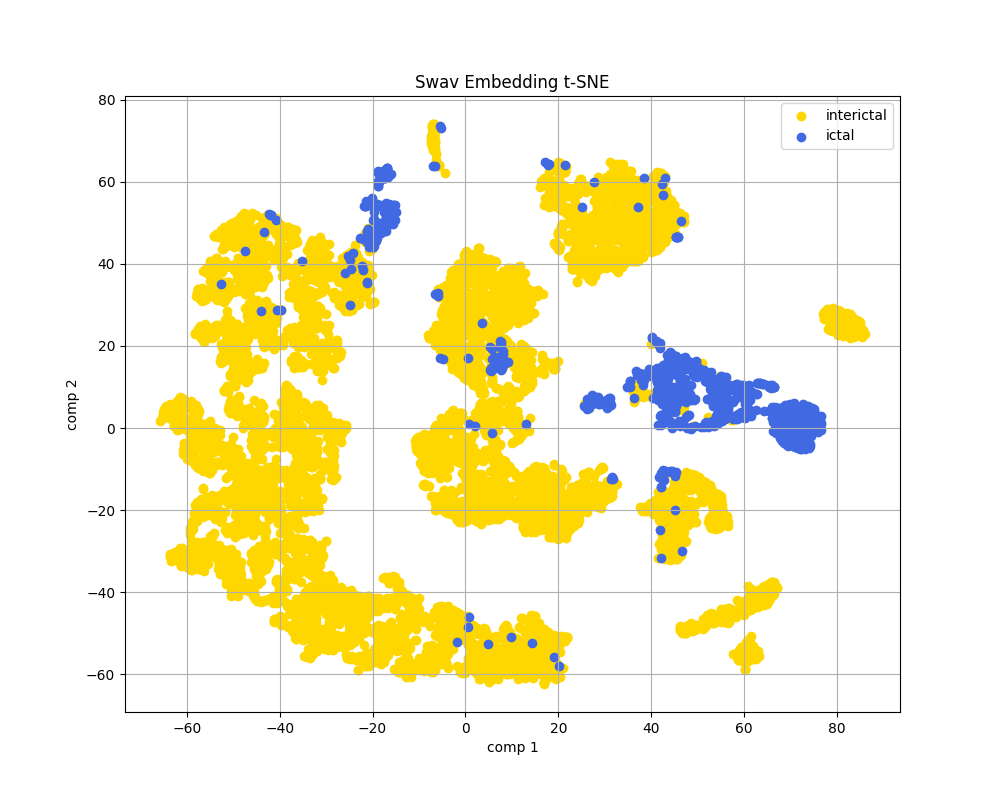

In [31]:
spc = z

plt.figure(figsize=(10, 8))
plt.scatter(spc[interictal_inds,0],spc[interictal_inds,1],c='gold',label= 'interictal')
plt.scatter(spc[ictal_inds,0],spc[ictal_inds,1],c='royalblue',label= 'ictal')
plt.title('Swav Embedding t-SNE')
plt.xlabel('comp 1')
plt.ylabel("comp 2" )
plt.legend()
plt.grid()
plt.show()

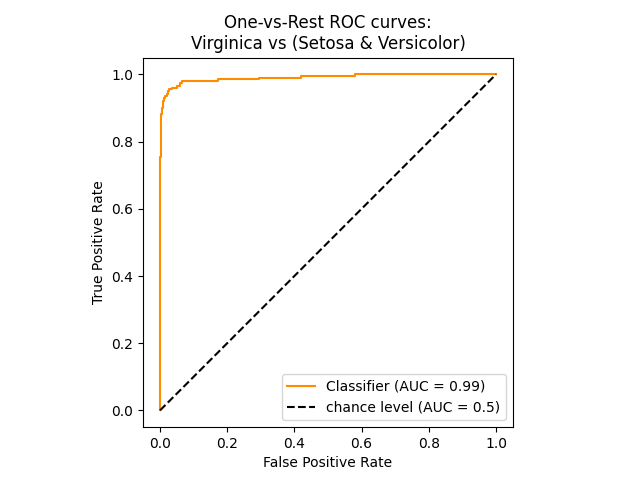

In [41]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(
    target,
    output[:,1],
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [30]:
output[:,1]

tensor([5.6110e-03, 1.2324e-05, 1.9366e-02,  ..., 2.1341e-04, 9.9074e-05,
        1.3103e-04])

array([   0,    1,    2, ..., 2038, 2039, 2040], dtype=int64)

In [19]:

output = torch.argmax(output, dim=1)
output = output.detach().cpu().numpy()
target= target.squeeze().detach().cpu().numpy()

In [20]:
import sklearn

clf_report = sklearn.metrics.classification_report(output, target, digits=6)

print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0   0.995647  0.987055  0.991333      1854
           1   0.881773  0.957219  0.917949       187

    accuracy                       0.984321      2041
   macro avg   0.938710  0.972137  0.954641      2041
weighted avg   0.985214  0.984321  0.984609      2041



In [21]:
for batch, label in tqdm(val_dataloader):
        batch = batch.to(device)
        label = label.to(device)
        label = F.one_hot(label).squeeze()
        outputs = model(batch)
        print(batch)
        loss = sigmoid_focal_loss(pred.float(),label.float(), alpha = 0.5, gamma = 8,reduction = 'mean')
        print(loss)
        break

  0%|          | 0/15 [00:00<?, ?it/s]


NotImplementedError: Module [SupervisedDownstream] is missing the required "forward" function

In [ ]:
# import copy
# import torch
# import torchvision
# from torch import nn
#
# from lightly.data import DINOCollateFunction, LightlyDataset
# from lightly.loss import DINOLoss
# from lightly.models.modules import DINOProjectionHead
# from lightly.models.utils import deactivate_requires_grad, update_momentum
# from lightly.utils.scheduler import cosine_schedule
#
#
# class DINO(torch.nn.Module):
#     def __init__(self, backbone, input_dim):
#         super().__init__()
#         self.student_backbone = backbone
#         self.student_head = DINOProjectionHead(
#             input_dim, 512, 64, 2048, freeze_last_layer=1
#         )
#         self.teacher_backbone = copy.deepcopy(backbone)
#         self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
#         deactivate_requires_grad(self.teacher_backbone)
#         deactivate_requires_grad(self.teacher_head)
#
#     def forward(self, x):
#         y = self.student_backbone(x).flatten(start_dim=1)
#         z = self.student_head(y)
#         return z
#
#     def forward_teacher(self, x):
#         y = self.teacher_backbone(x).flatten(start_dim=1)
#         z = self.teacher_head(y)
#         return z
#
#
# resnet = torchvision.models.resnet18()
# backbone = nn.Sequential(*list(resnet.children())[:-1])
# input_dim = 512
# # instead of a resnet you can also use a vision transformer backbone as in the
# # original paper (you might have to reduce the batch size in this case):
# # backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=False)
# # input_dim = backbone.embed_dim
#
# model = DINO(backbone, input_dim)
#
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)
#
# # # we ignore object detection annotations by setting target_transform to return 0
# # pascal_voc = torchvision.datasets.VOCDetection(
# #     "datasets/pascal_voc", download=True, target_transform=lambda t: 0
# # )
# # dataset = LightlyDataset.from_torch_dataset(pascal_voc)
# # # or create a dataset from a folder containing images or videos:
# # # dataset = LightlyDataset("path/to/folder")
#
# collate_fn = DINOCollateFunction(solarization_prob = 0, hf_prob = 0,vf_prob = 0,rr_prob=0,cj_prob=0,random_gray_scale=0)
#
# dataloader = torch.utils.data.DataLoader(
#     train_set,
#     batch_size=64,
#     collate_fn=collate_fn,
#     shuffle=True,
#     drop_last=True,
#     num_workers=1,
# )
#
# criterion = DINOLoss(
#     output_dim=2048,
#     warmup_teacher_temp_epochs=5,
# )
# # move loss to correct device because it also contains parameters
# criterion = criterion.to(device)
#
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
# epochs = 10
#
# print("Starting Training")
# for epoch in range(epochs):
#     total_loss = 0
#     momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)
#     for views, _, _ in tqdm(dataloader):
#         update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
#         update_momentum(model.student_head, model.teacher_head, m=momentum_val)
#         views = [view.to(device) for view in views]
#         global_views = views[:2]
#         teacher_out = [model.forward_teacher(view) for view in global_views]
#         student_out = [model.forward(view) for view in views]
#         loss = criterion(teacher_out, student_out, epoch=epoch)
#         total_loss += loss.detach()
#         loss.backward()
#         # We only cancel gradients of student head.
#         model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

In [ ]:
augmentation = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 512), interpolation=T.InterpolationMode.NEAREST),
    T.RandomApply([T.ColorJitter()], p=0.5),
    T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
    T.RandomInvert(p=0.2),
    T.RandomPosterize(4, p=0.2),
])

data = ictal_data_X[0]

channel_index = np.arange(data.shape[0])
np.random.shuffle(channel_index)
data = data[channel_index]
data = torch.from_numpy(data).clone()
data = data.repeat(3, 1, 1)
data = augmentation(data)
data

In [ ]:
channel_index

In [ ]:
data[channel_index]

In [ ]:
data

In [ ]:
#
# print("Starting Training")
# for epoch in range(50):
#     total_loss = 0
#     i = 0
#     for batch, label in tqdm(dataloader):
#         batch = batch.to(device)
#         # print(type(batch))
#         label = label.to(device)
#         label = F.one_hot(label).squeeze()
#         outputs = model(batch)
#         loss = sigmoid_focal_loss(outputs.float(),label.float(), alpha = 0.25, gamma = 7,reduction = 'mean')
#         total_loss += loss.detach()
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss,
#             }, 'ckpt/checkpoint'+str(epoch)+'.pth')
#
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")